![](aux/titlepage.png)

# Part II: Automatic Differentiation with Zygote.jl

![Zygote.jl](aux/Zygote.png)

## Why I personally use Julia

![Julia](aux/WhyIUseJulia.png)

For me, this becomes particularly apparent in the context of automatic differentiation. Here, Julia's main AD system, the [`Zygote.jl` package](https://github.com/FluxML/Zygote.jl), offers a particularly flexible and straightforward way of getting gradients of essentially arbitrary pieces of code. I will illustrate this with a modelling example in a COVID-19 context in the following.

The notebook is an adaptation of the notebooks in [this repository](https://github.com/maren-ha/DifferentiableProgrammingForStatisticalModeling) and slides from a presentation I gave about this at the Statistical Computing Workshop at Reisensburg Castle in July 2022.

## Exemplary modelling challenge

First, let's load and install the necessary packages as usual. 

In [11]:
using Pkg;
#Pkg.activate("aux/")
#Pkg.add(["GLM", "ProgressMeter", "StatsBase", "Zygote"])
#Pkg.instantiate()  # uncomment if you want to run this notebook yourself under the same environment as the author

Pkg.status()

using CSV 
using DataFrames
using GLM 
using LinearAlgebra
using ProgressMeter
using Random
using Statistics
using StatsBase
using StatsPlots
using VegaLite
using Zygote 

┌ Warning: Module FilePathsBase with build ID ffffffff-ffff-ffff-0000-071885f90277 is missing from the cache.
│ This may mean FilePathsBase [48062228-2e41-5def-b9a4-89aafe57970f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module FilePathsBase with build ID ffffffff-ffff-ffff-0000-071885f90277 is missing from the cache.
│ This may mean FilePathsBase [48062228-2e41-5def-b9a4-89aafe57970f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module FilePathsBase with build ID ffffffff-ffff-ffff-0000-071885f90277 is missing from the cache.
│ This may mean FilePathsBase [48062228-2e41-5def-b9a4-89aafe57970f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module FilePaths with build ID ffffffff-ffff-ffff-0000-072ebee50560 is missing from the cache.
│ This may mean FilePaths [8fc22ac5-c921-52a6-82fd-178b2807b824] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Compat with build ID ffffffff-ffff-ffff-0000-0718b8a0ae58 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Compat with build ID ffffffff-ffff-ffff-0000-0718b8a0ae58 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Compat with build ID ffffffff-ffff-ffff-0000-0718b8a0ae58 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module Compat with build ID ffffffff-ffff-ffff-0000-0718b8a0ae58 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Compat with build ID ffffffff-ffff-ffff-0000-0718b8a0ae58 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module Compat with build ID ffffffff-ffff-ffff-0000-0718b8a0ae58 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module Compat with build ID ffffffff-ffff-ffff-0000-0718b8a0ae58 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


┌ Warning: Module ChainRulesCore with build ID ffffffff-ffff-ffff-0000-072fe7128a52 is missing from the cache.
│ This may mean ChainRulesCore [d360d2e6-b24c-11e9-a2a3-2a2ae2dbcce4] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


Status `~/UiO/Docs/Meetings/public-slides/Presentations/aux/Project.toml`
  [336ed68f] CSV v0.10.11
⌃ [a93c6f00] DataFrames v1.3.6
  [31c24e10] Distributions v0.25.96
  [38e38edf] GLM v1.8.3
  [91a5bcdd] Plots v1.38.16
  [92933f4c] ProgressMeter v1.7.2
  [2913bbd2] StatsBase v0.34.0
  [f3b207a7] StatsPlots v0.15.5
⌃ [fce5fe82] Turing v0.26.1
  [112f6efa] VegaLite v3.2.2
  [e88e6eb3] Zygote v0.6.62
Info Packages marked with ⌃ have new versions available and may be upgradable.


At the beginning of the pandemic, our institute was asked by the Robert Koch Institute, the main health authority that monitored the COVID-19 pandemic in Germany, and the Federal Ministry for Health, to build a prediction model for COVID-19 ICU demand. The data we were given was a newly-set-up intensive care registry, where each ICU in Germany was required to report daily their numbers of COVID-19 patients in ICUs and normal wards, alongside a bunch of other information. Even though daily reporting was compulsory, the data was still very messy, with many ICUs not reporting at all, and many others reporting only sporadically.

To get an idea what the data looked like, let's look at an exemplary hospital from the registry during a period in spring - early summer 2020. 

Note that the values shown in `:currentcases` have been imputed based on last-observation-carried-forward whenever a report has been missing, as indicated by a $0$ in the `:reported`column. 

In [12]:
#load data  
all_hospitals_df = CSV.read("aux/data_all_hospitals.csv", DataFrame)
myhospital = all_hospitals_df[all_hospitals_df[!,:hospital] .== 40, [:date, :currentcases, :reported]]
first(myhospital, 10)

,date,currentcases,reported
,Date,Float64,Bool
1,2020-04-16,0.0,0
2,2020-04-17,0.0,1
3,2020-04-18,0.0,1
4,2020-04-19,0.0,1
5,2020-04-20,2.0,1
6,2020-04-21,0.0,1
7,2020-04-22,1.0,1
8,2020-04-23,2.0,1
9,2020-04-24,2.0,1


We replace all numbers in `:currentcases` that have been imputed by last-observation-carried-forward with `NaN`, i.e., all values in rows where `:reported` is equal to $0$, and plot the number of current cases over the time interval to visualize the missingness pattern.

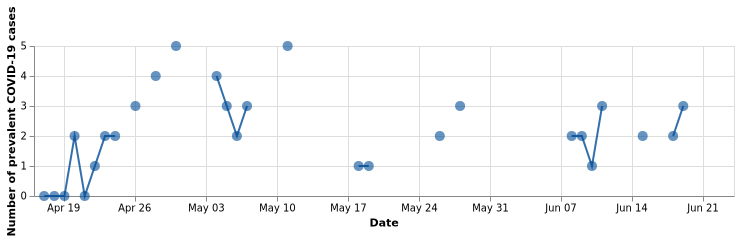

In [13]:
myhospital[findall(x -> x == false, myhospital[:,:reported]),:currentcases] .= NaN;

figure1=myhospital|> @vlplot(
        width=700, height=150,
        mark={:line, point={filled=true, size=100, color="#004b96", opacity = 0.6}, color="#004b96", opacity=0.8}, 
        x={field=:date, axis={title="Date"}},
        y={field=:currentcases, axis={title="Number of prevalent COVID-19 cases"}}
) 

Now, imagine standing at say, May 31, having had several days of missing reports, and being tasked with making a prediction for what's going to happen next...? 

![](aux/PredictionNeeded.png)

So here's what we did: We developed a model to predict increments of daily cases, i.e., *changes* in cases from one day to the next. Since the pandemic dynamics differed wildly between different regions and larger and smaller hospitals, we needed individual models for each hospital. We used a simple linear model: 

![](aux/IncrementModel.png)

To account for missing daily reports in our model, we needed to figure out what to do when the number of prevalent cases from the day before is missing. If the number of cases from the day before hasn’t been reported, we take the value from the day before that, and add the model prediction for the change from day $t-1$ to $t$, to we just propagate the model prediction forwards in time from the last observed value, until we have a new observation available: 

![](aux/IncrementModel2.png)

To  illustrate what this means in practice, let's look at different situations in some imaginary hospitals: 

![](aux/HospitalsMissing.png)

The problem with this is that it leads to higher-order terms in the coefficients, and thus a non-linear optimisation problem: 

![](aux/NonlinearOptProb.png)

But, even though maximum likelihood estimation suddenly becomes rather challenging and we cannot write down the model in closed form, it *is* quite straightforward to write down the model loss function as a computer program -- and that's all we need to do automatic differentiation. At least with a flexible system like `Zygote.jl`, where we can differentiate pretty much everything that we can write as code (provided it's differentiable, of course), and thus still estimate model parameters.

In [14]:
function loss(y, z, r, β)
    sqerror = 0.0 # squared error
    firstseen = false # set to true after skipping potential missings 
    last_y = 0.0 # prevalent cases from previous time point
    contribno = 0.0 # number of non-missing observations

    for t = 1:length(y)
        # skip missings at the start until first reported value
        if !firstseen 
            if r[t] == 1
                firstseen = true
                last_y = y[t]
            else
                continue
            end
        else # make a prediction for the current increment
            pred_dy = β[1] + β[2] * last_y + β[3] * z[t-1] 
            if r[t] == 1
                dy = y[t] - last_y
                sqerror += (dy - pred_dy)^2
                contribno += 1.0
                last_y = y[t]
            else
                last_y += pred_dy
            end 
        end
    end
    return sqerror/contribno # return MSE over all reported time points end
end

loss (generic function with 1 method)

So let's see how it's done in Julia! We use automatic differentiation to optimize the model parameters, $\beta$, by gradient descent on the loss function. 

In [15]:
# get the data for our chosen hospital
myhospital = all_hospitals_df[all_hospitals_df[!,:hospital] .== 40, :]
y, z, r = myhospital[1:end-1,:currentcases], myhospital[1:end-1,:incidences], myhospital[1:end-1,:reported]
# set aside the last time point in the data to evaluate our prediction on: 
last_currentcases, lastreported = myhospital[end,:currentcases], myhospital[end,:reported]

# initialize the parameters
β = [0.0, 0.0, 0.0]
losses = [] # save losses during training
for epoch=1:1000
    curgrad = gradient(arg -> loss(y, z, r, arg), β)
    β .-= [0.001, 0.01, 0.001] .* curgrad[1]
    push!(losses, loss(y, z, r, β))
end

We can now visualise the loss: 

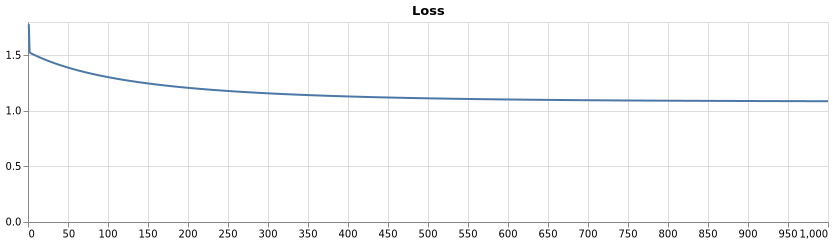

In [16]:
@vlplot(:line, x = {collect(1:1000), type="quantitative"}, y={losses, type="quantitative"}, width=800, title="Loss")

Now, we can do this for all hospitals, and compare the different benchmark models and their prediction errors. 

We initialise the parameters `betas` and `lrbetas` for both the increment model and the standard linear regression model estimated via classical maximum likelihood. For each model, we also initialize an array for the predictions from this model for each hospital.  

In [17]:
nhospitals = length(unique(all_hospitals_df[:,:hospital]))

1281

In [18]:
betas = collect([0.0; 0.0; 0.0] for i in 1:nhospitals)
lrbetas = collect([0.0; 0.0; 0.0] for i in 1:nhospitals)

prederrs_mean = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_modmean = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_zero = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_linreg = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_incrmod = Array{Union{Float64, Missing}}(missing, nhospitals);

In [19]:
@time for i = 1:nhospitals
    # get the covariates and info about missing reports
    curhospital = filter(row -> row[:hospital] == i, all_hospitals_df)
    y, z, r = curhospital[1:end-1,:currentcases], curhospital[1:end-1,:incidences], curhospital[1:end-1,:reported]
    last_currentcases, lastreported = curhospital[end,:currentcases], curhospital[end,:reported]

    # run the gradient descent via automatic differentiation/differentiable programming
    β = betas[i]
    for epoch=1:150
        curgrad = gradient(arg -> loss(y, z, r, arg), β)
        β .-= [0.001, 0.01, 0.001] .* curgrad[1]
    end
    betas[i] = β

    # calculate last increment based on the held-out final time point 
    lastincr = last_currentcases - y[end]

    # calculate the prediction of the fitted models for this last increment
    incrmod_pred = β[1] + β[2] * y[end] + β[3] * z[end]

    # calculate the prediction of the mean and modified mean models
    mean_pred = mean(diff(y))
    modmean_pred = y[end] == 0.0 ? 0.0 : mean_pred

    # coarse heuristic: if the fit goes wrong, use the mean model prediction as fallback
    if isnan(incrmod_pred) || any(abs.(β) .> 10)
        incrmod_pred = mean_pred
    end

    # fit standard linear regression model using the last-observation-carried-forward imputation in the :currentcases
    slrdf = DataFrame(dy = diff(y), y = y[2:end], z = z[2:end])
    ols = lm(@formula(dy ~ y + z), slrdf) # standard estimation using maximum likelihood
    lrbeta = coef(ols) 
    lrbetas[i] = lrbeta
    # calculate prediction of the standard linear regression model for the last increment 
    linreg_pred = lrbeta[1] + lrbeta[2] * y[end] + lrbeta[3] * z[end]

    # include in the prediction error array only if the value at the last time point has actually been reported
    if lastreported 
        prederrs_mean[i] = (lastincr - mean_pred)^2
        prederrs_modmean[i] = (lastincr - modmean_pred)^2
        prederrs_zero[i] = (lastincr - 0)^2
        prederrs_linreg[i] = (lastincr - linreg_pred)^2
        prederrs_incrmod[i] = (lastincr - incrmod_pred)^2
    end
end

121.561528 seconds (1.58 G allocations: 63.377 GiB, 24.63% gc time, 5.99% compilation time)


We can now combine the prediction errors for all models in a dataframe and calculate summary statistics. 

In [20]:
nonmissinginds = findall(x -> !ismissing(x), prederrs_mean)
prederrs_df = DataFrame(hospitals = nonmissinginds,
                meanmodel = Float64.(prederrs_mean[nonmissinginds]),
                modmeanmodel = Float64.(prederrs_modmean[nonmissinginds]),
                zeromodel = Float64.(prederrs_zero[nonmissinginds]),
                linregmodel = Float64.(prederrs_linreg[nonmissinginds]),
                incrmodel = Float64.(prederrs_incrmod[nonmissinginds])
)
models = names(prederrs_df[!,2:end])
summed_squared_errors = sum.(eachcol(prederrs_df[!,2:end]))
medians = round.(median.(eachcol(prederrs_df[!,2:end])), digits=3)
firstquartile = round.(quantile.(eachcol(prederrs_df[!,2:end]), 0.25), digits=3)
thirdquartile = round.(quantile.(eachcol(prederrs_df[!,2:end]), 0.75), digits=3)
maxvals = round.(maximum.(eachcol(prederrs_df[!,2:end])), digits=3)
summary_df = DataFrame(Model = models, 
                    SSE = summed_squared_errors,
                    FirstQuartile = firstquartile,
                    Median = medians, 
                    ThirdQuartile = thirdquartile,
                    Maximum = maxvals
)

,Model,SSE,FirstQuartile,Median,ThirdQuartile,Maximum
,String,Float64,Float64,Float64,Float64,Float64
1,meanmodel,89.2388,0.0,0.0,0.002,9.0
2,modmeanmodel,84.3421,0.0,0.0,0.0,9.0
3,zeromodel,86.0,0.0,0.0,0.0,9.0
4,linregmodel,181.068,0.0,0.001,0.015,30.227
5,incrmodel,74.7457,0.0,0.0,0.001,6.079


If you want to know more details, you can [read the paper](https://doi.org/10.1080/00031305.2021.2002189) ([arXiv version here](https://arxiv.org/abs/2012.05722)) or have a closer look at the [GitHub repository](https://github.com/maren-ha/DifferentiableProgrammingForStatisticalModeling) with the code + Jupyter notebooks to reproduce all analyses and images. 

![](auxiliary/TAS.png)